In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [2]:
NUM_TRADING_DAYS = 1260 #252*5
NUM_PORTFOLIOS = 10000
stocks = ["JPM", "GS", "MSFT", "AAPL", "CO", "WMT", "DIS", "BA", "MCD", "NKE"]

In [3]:
start_date = '2016-01-01' # YY/MM/DD
end_date = '2020-12-31'   # YY/MM/DD

In [4]:
def download_data():
    stock_data = {}
    for stock in stocks:
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date, )['Close']

    return pd.DataFrame(stock_data)

In [5]:
def show_data(data):
    data.plot(figsize=(8, 5))
    plt.show()

In [6]:
def calculate_return(data):
    log_return = np.log(data / data.shift(1))
    return log_return[1:]

In [7]:
def show_statistics(returns):
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [8]:

def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print('Expected portfolio mean: ', portfolio_return)
    print('Expected portfolio volatility: ', portfolio_volatility)


In [9]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(8, 5))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [10]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

In [11]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [12]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

In [13]:
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]


In [14]:
def optimize_portfolio(weights, returns):
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP',
                                 bounds=bounds, constraints=constraints)


In [15]:
def print_optimal_portfolio(optimum, returns):
    print('Optimal Portfolio: ', optimum['x'].round(3))
    print('Expected return, volatility and sharpe ratio: ', statistics(optimum['x'].round(3), returns))


In [16]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(8, 5))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


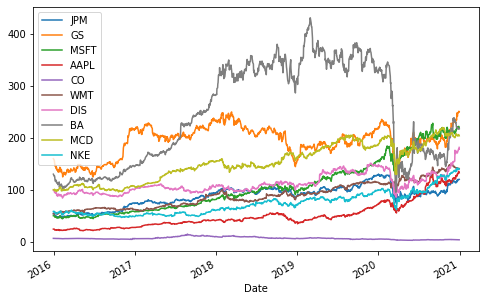

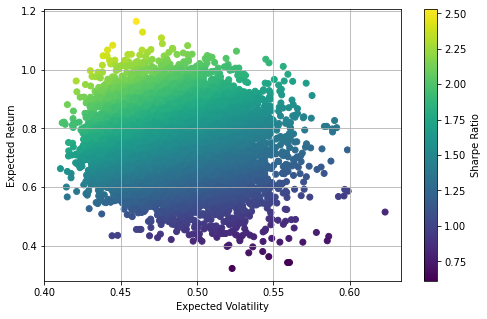

Optimal Portfolio:  [0.    0.    0.229 0.392 0.    0.379 0.    0.    0.    0.   ]
Expected return, volatility and sharpe ratio:  [1.37497167 0.48492929 2.83540652]


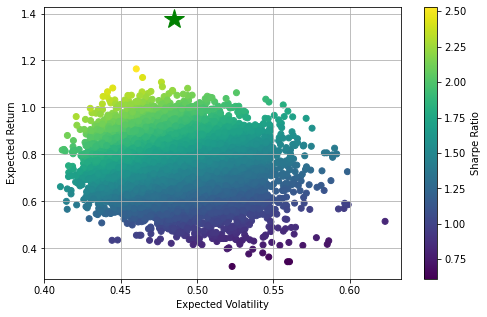

In [17]:
if __name__ == '__main__':
    # print(download_data())
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)
    # show_mean_variance(log_daily_returns, [0.1, 0.2, 0.3, 0.2, 0.1, 0.1])
    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)